
=== Conv1 (Low-level) (32 channels) ===
ch=  0 iter=100 J=0.6900 TV=12.4489 L2=777.6518
ch=  0 iter=200 J=0.6900 TV=12.1886 L2=777.6859
ch=  0 iter=300 J=0.6900 TV=12.4104 L2=777.4814
ch=  4 iter=100 J=2.2709 TV=4.2488 L2=1568.0071
ch=  4 iter=200 J=2.2709 TV=3.8984 L2=1568.0063
ch=  4 iter=300 J=2.2709 TV=3.6028 L2=1568.0049
ch=  8 iter=100 J=-0.0113 TV=17.2513 L2=4.8187
ch=  8 iter=200 J=-0.0113 TV=17.5583 L2=4.8812
ch=  8 iter=300 J=-0.0113 TV=17.4770 L2=4.8699
ch= 12 iter=100 J=0.4373 TV=100.3636 L2=821.7474
ch= 12 iter=200 J=0.4373 TV=101.0432 L2=821.6282
ch= 12 iter=300 J=0.4373 TV=100.8741 L2=821.6766
ch= 16 iter=100 J=1.1068 TV=0.0000 L2=1568.0000
ch= 16 iter=200 J=1.1068 TV=0.0000 L2=1568.0000
ch= 16 iter=300 J=1.1068 TV=0.0000 L2=1568.0000
ch= 20 iter=100 J=1.5390 TV=39.2687 L2=816.7683
ch= 20 iter=200 J=1.5390 TV=39.2813 L2=816.7135
ch= 20 iter=300 J=1.5390 TV=39.3237 L2=816.6766
ch= 24 iter=100 J=0.6403 TV=55.8811 L2=1799.4050
ch= 24 iter=200 J=0.6403 TV=56.0728 L2=1799.38

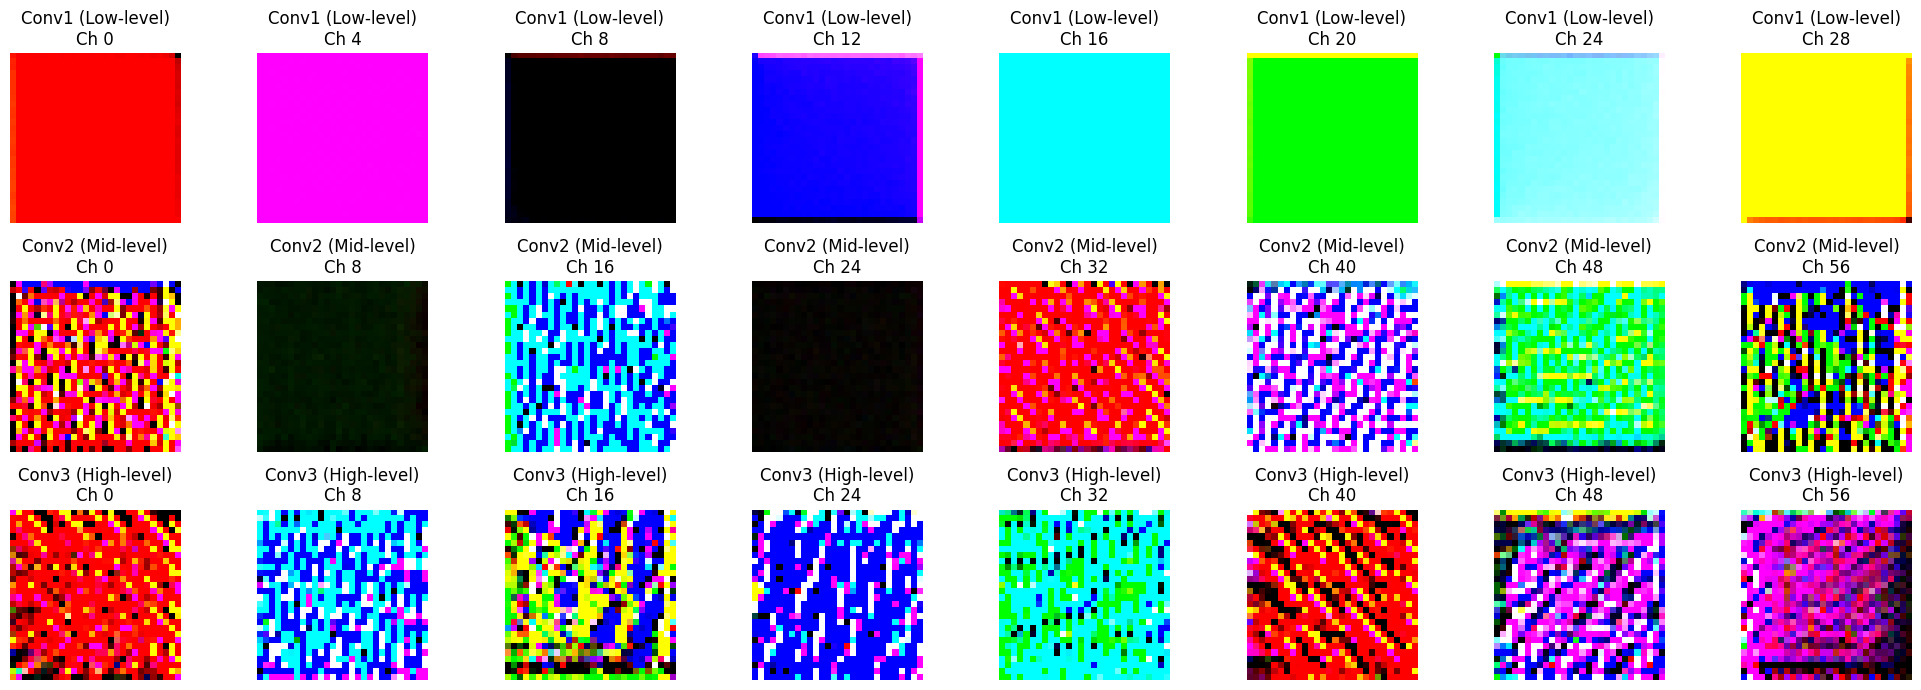

In [9]:
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================
# 1. Model definition
# ==========================

class CNN3Layer(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN3Layer, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))   # 3x28x28 -> 32x14x14
        x = self.pool2(torch.relu(self.conv2(x)))   # 32x14x14 -> 64x7x7
        x = self.pool3(torch.relu(self.conv3(x)))   # 64x7x7 -> 64x3x3
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# load trained Task-1 model
model = CNN3Layer().to(device)
ckpt_path = "/kaggle/input/task1-v2/pytorch/default/1/task1_v2.pth"
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

# ==========================
# 2. Regularizers
# ==========================

def total_variation(x):
    """Total variation regularizer for smoothness."""
    diff_x = x[:, :, 1:, :] - x[:, :, :-1, :]
    diff_y = x[:, :, :, 1:] - x[:, :, :, :-1]
    return diff_x.abs().sum() + diff_y.abs().sum()

# ==========================
# 3. Single neuron/channel visualizer
# ==========================

def visualize_neuron(
    model,
    layer,
    channel_idx,
    iterations=300,
    lr=0.1,
    tv_weight=1e-4,
    l2_weight=1e-4,
    clamp_min=0.0,
    clamp_max=1.0
):
    """
    Optimize an image [1, 3, 28, 28] to maximize mean activation of one channel.
    Adds TV + L2 regularization for nicer visuals.
    """
    # random noise input
    input_img = torch.rand(1, 3, 28, 28, device=device, requires_grad=True)

    optimizer = optim.Adam([input_img], lr=lr)

    activations = {}
    def hook_fn(module, inp, out):
        activations["value"] = out

    hook = layer.register_forward_hook(hook_fn)

    for i in range(iterations):
        optimizer.zero_grad()
        model(input_img)

        feat = activations["value"]        # [1, C, H, W]
        c = min(channel_idx, feat.size(1) - 1)
        channel_act = feat[0, c, :, :]

        # main objective: maximize mean activation
        J = channel_act.mean()

        # regularizers
        tv_loss = total_variation(input_img)
        l2_loss = (input_img ** 2).sum()

        # we minimize loss = -J + reg
        loss = -J + tv_weight * tv_loss + l2_weight * l2_loss
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            input_img.clamp_(clamp_min, clamp_max)

        if (i + 1) % 100 == 0:
            print(f"ch={channel_idx:3d} iter={i+1:3d} J={J.item():.4f} "
                  f"TV={tv_loss.item():.4f} L2={l2_loss.item():.4f}")

    hook.remove()

    img_result = input_img.detach().cpu().squeeze(0)  # [3, 28, 28]
    return img_result

# ==========================
# 4. Run across layers & channels
# ==========================

layers_to_probe = {
    "Conv1 (Low-level)": model.conv1,
    "Conv2 (Mid-level)": model.conv2,
    "Conv3 (High-level)": model.conv3
}

num_samples = 8   # channels per layer
save_dir = "feature_vis"
os.makedirs(save_dir, exist_ok=True)

fig, axes = plt.subplots(len(layers_to_probe), num_samples, figsize=(2.5 * num_samples, 7))

for row, (name, layer) in enumerate(layers_to_probe.items()):
    max_channels = layer.out_channels
    print(f"\n=== {name} ({max_channels} channels) ===")

    for col in range(num_samples):
        # spread channels across the layer
        idx = (max_channels // num_samples) * col
        idx = min(idx, max_channels - 1)

        img_chw = visualize_neuron(
            model,
            layer,
            channel_idx=idx,
            iterations=300,
            lr=0.1,
            tv_weight=1e-4,
            l2_weight=1e-4
        )

        # CHW -> HWC for imshow
        img_hwc = img_chw.permute(1, 2, 0).numpy()
        axes[row, col].imshow(img_hwc)
        axes[row, col].set_title(f"{name}\nCh {idx}")
        axes[row, col].axis("off")

        # also save individual images if you want
        out_path = os.path.join(save_dir, f"{name.replace(' ', '_')}_ch_{idx}.png")
        vutils.save_image(img_chw, out_path)

plt.tight_layout()
plt.show()
